
# Verifying that low-dimensional RBF models are resistant to adversarial Exemples


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Define the RBF layer and the RBF model

In [2]:
class RBFLayer(layers.Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = gamma

    def build(self, input_shape):
        self.centers = self.add_weight(name='centers',
                        shape=(self.units, input_shape[1]),
                        initializer='uniform',
                        trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        # Expanding the dimensions of inputs and centers for computational purposes
        expanded_inputs = tf.expand_dims(inputs, 1)  # Shape: (batch_size, 1, num_features)
        expanded_centers = tf.expand_dims(self.centers, 0)  # Shape: (1, units, num_features)
        # Calculate the Euclidean distance
        distances = tf.reduce_sum(tf.square(expanded_inputs - expanded_centers), axis=-1)
        # Applying RBF Functions
        return tf.exp(-self.gamma * distances)

def create_rbf_model(input_shape, num_classes, units, gamma):
    model = models.Sequential()
    model.add(RBFLayer(units, gamma, input_shape=input_shape))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

# Load MNIST dataset/Generate adversarial samples/Preprocess data

In [3]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()


# Functions to create antagonistic samples
def create_adversarial_pattern(input_image, input_label, model, epsilon=0):
    input_image = tf.convert_to_tensor(input_image, dtype=tf.float32)
    input_label = tf.convert_to_tensor(input_label, dtype=tf.int64)
    loss_object = tf.keras.losses.CategoricalCrossentropy()

    # Batch processing of data
    batch_size = 1000
    num_batches = input_image.shape[0] // batch_size
    perturbations = []

    for i in range(num_batches):
        start = i * batch_size
        end = (i + 1) * batch_size
        batch_input_image = input_image[start:end]
        batch_input_label = input_label[start:end]

        with tf.GradientTape() as tape:
            tape.watch(batch_input_image)
            prediction = model(batch_input_image)
            loss = loss_object(batch_input_label, prediction)
        gradient = tape.gradient(loss, batch_input_image)
        signed_grad = tf.sign(gradient)
        batch_perturbations = epsilon * signed_grad
        perturbations.append(batch_perturbations)

    perturbations = tf.concat(perturbations, axis=0)
    return perturbations

# Preprocessed data
x_train = x_train.reshape((x_train.shape[0], -1)).astype('float32') / 255
x_test = x_test.reshape((x_test.shape[0], -1)).astype('float32') / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)


# Training/Evaluation model

In [4]:
# Creating shallow RBF models
rbf_model = create_rbf_model(input_shape=(784,), num_classes=10, units=512, gamma=0.05)

# Compilation model
rbf_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training model
rbf_model.fit(x_train, y_train, epochs=20, batch_size=128, validation_data=(x_test, y_test))

# Evaluation Models
loss, accuracy = rbf_model.evaluate(x_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/20
469/469 [==============================] - 11s 19ms/step - loss: 1.8007 - accuracy: 0.4851 - val_loss: 1.2258 - val_accuracy: 0.7512
Epoch 2/20
469/469 [==============================] - 8s 17ms/step - loss: 0.8446 - accuracy: 0.8266 - val_loss: 0.6049 - val_accuracy: 0.8688
Epoch 3/20
469/469 [==============================] - 8s 17ms/step - loss: 0.5314 - accuracy: 0.8777 - val_loss: 0.4509 - val_accuracy: 0.8970
Epoch 4/20
469/469 [==============================] - 8s 17ms/step - loss: 0.4287 - accuracy: 0.8974 - val_loss: 0.3796 - val_accuracy: 0.9114
Epoch 5/20
469/469 [==============================] - 7s 16ms/step - loss: 0.3716 - accuracy: 0.9091 - val_loss: 0.3343 - val_accuracy: 0.9196
Epoch 6/20
469/469 [==============================] - 8s 18ms/step - loss: 0.3333 - accuracy: 0.9172 - val_loss: 0.3039 - val_accuracy: 0.9256
Epoch 7/20
469/469 [==============================] - 8s 17ms/step - loss: 0.3047 - accuracy: 0.9233 - val_loss: 0.2797 - val_accuracy: 0.930

# Evaluating model performance on adversarial samples

In [5]:
# Generating Adversarial Samples
epsilon = 0.25  # The size of the antagonistic perturbation
perturbations = create_adversarial_pattern(x_train, y_train, rbf_model, epsilon=epsilon)
adv_x_train = x_train + perturbations.numpy()

# Evaluating model performance on adversarial samples
adv_loss, adv_accuracy = rbf_model.evaluate(adv_x_train, y_train)
print(f'Adversarial Loss: {adv_loss}, Adversarial Accuracy: {adv_accuracy}')

1875/1875 [==============================] - 6s 3ms/step - loss: 2.4779 - accuracy: 0.1562
Adversarial Loss: 2.4778997898101807, Adversarial Accuracy: 0.15623334050178528


# Calculate model confidence

In [6]:
# Model prediction and confidence calculation
def model_predictions(model, original_images, adversarial_images):
    # Predicting the original image
    original_preds = model.predict(original_images)

    # Predicting Adversarial Images
    adversarial_preds = model.predict(adversarial_images)

    # Get confidence level (highest probability value)
    original_confidences = np.max(original_preds, axis=1)
    adversarial_confidences = np.max(adversarial_preds, axis=1)

    # Get Predictive Labeling
    original_labels = np.argmax(original_preds, axis=1)
    adversarial_labels = np.argmax(adversarial_preds, axis=1)

    return original_labels, original_confidences, adversarial_labels, adversarial_confidences

# Generating images

1875/1875 [==============================] - 4s 2ms/step


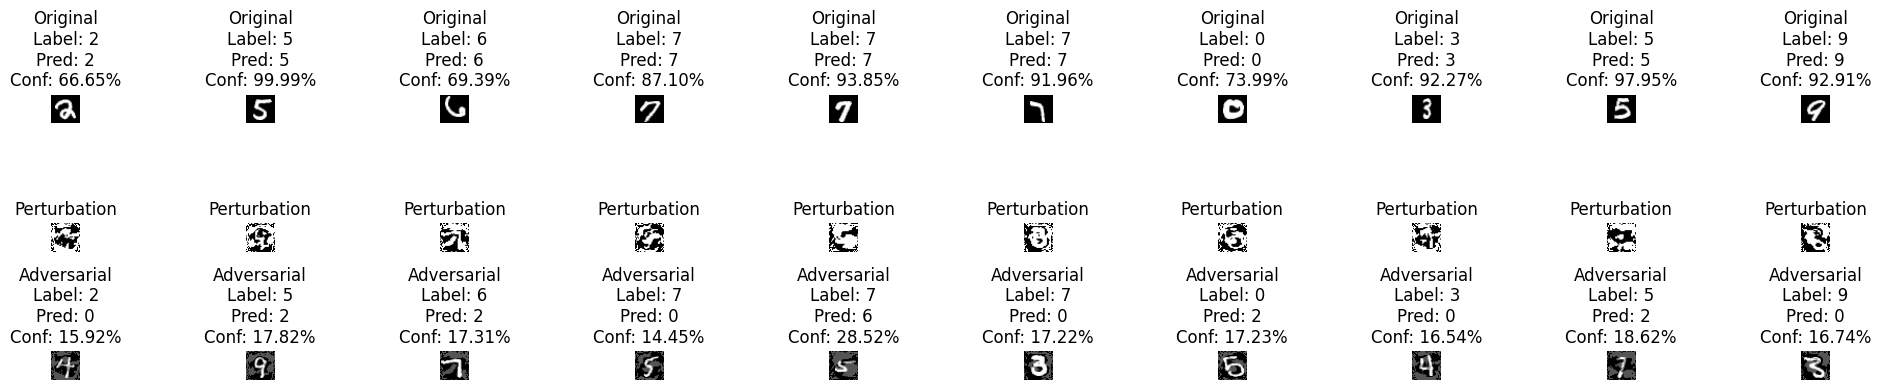

In [7]:
# Visualization Function
def visualize_adversarial_samples(x, y_true, perturbations, adv_x, model):
    num_samples = 10
    indices = np.random.choice(range(len(x)), size=num_samples, replace=False)
    num_rows = 3
    plt.figure(figsize=(2 * num_samples, 4))

    # Getting predictions from the model
    original_preds = model.predict(x)
    adversarial_preds = model.predict(adv_x)

    # For original and adversarial images, obtain predictive labels and confidence levels
    original_labels = np.argmax(original_preds, axis=1)
    original_confidences = np.max(original_preds, axis=1)
    adversarial_labels = np.argmax(adversarial_preds, axis=1)
    adversarial_confidences = np.max(adversarial_preds, axis=1)

    for i, index in enumerate(indices):
        # Display original image
        plt.subplot(num_rows, num_samples, i + 1)
        plt.imshow(x[index].reshape(28, 28), cmap='gray')
        plt.axis('off')
        true_label = np.argmax(y_true[index])
        plt.title(f"Original\nLabel: {true_label}\nPred: {original_labels[index]}\nConf: {original_confidences[index]*100:.2f}%")

        # Display Disturbance
        plt.subplot(num_rows, num_samples, num_samples + i + 1)
        plt.imshow(perturbations[index].numpy().reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.title("Perturbation")

        # Display of confrontational images
        plt.subplot(num_rows, num_samples, 2 * num_samples + i + 1)
        plt.imshow(tf.keras.backend.eval(adv_x[index]).reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.title(f"Adversarial\nLabel: {true_label}\nPred: {adversarial_labels[index]}\nConf: {adversarial_confidences[index]*100:.2f}%")

    plt.tight_layout()
    plt.show()

# Visualization with functions
visualize_adversarial_samples(x_test, y_test, perturbations, adv_x_train, rbf_model)